In [3]:
import pandas as pd
import re
from transformers import AutoModel, AutoTokenizer
import torch
from annoy import AnnoyIndex
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import time
from collections import Counter

In [4]:
emoji_pattern = re.compile(
    "["
    "\U0001f600-\U0001f64f"
    "\U0001f300-\U0001f5ff"
    "\U0001f680-\U0001f6ff"
    "\U0001f1e0-\U0001f1ff"
    "\U00002700-\U000027bf"
    "\U000024c2-\U0001f251"
    "]+",
    flags=re.UNICODE,
)
markdown_pattern = re.compile(r"(\*{1,3}|#{1,6}|---)")
multi_space_pattern = re.compile(r"\s+")


In [ ]:
class CustomSentenceTransformer(torch.nn.Module):
    def __init__(self, model_name):
        super(CustomSentenceTransformer, self).__init__()

        # Use 'cuda' if available, else 'cpu'
        self.device = torch.device(
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

        # Load model with SentenceTransformer
        self.encoder = SentenceTransformer(model_name, device=self.device)

        # For E5 models, we need to add the instruction prefix
        self.is_e5 = "e5" in model_name.lower()
        self.query_prefix = "query: "
        self.passage_prefix = "passage: "

    def encode(self, sentences, batch_size=128, is_query=False, **kwargs):
        # Add instruction prefix for E5 models
        if self.is_e5:
            if is_query:
                sentences = [self.query_prefix + s for s in sentences]
            else:
                sentences = [self.passage_prefix + s for s in sentences]

        # Use the SentenceTransformer's encode method
        embeddings = self.encoder.encode(
            sentences,
            batch_size=batch_size,
            convert_to_tensor=True,
            normalize_embeddings=True,
            device=self.device,
            **kwargs,
        )
        return embeddings.cpu()  # Return on CPU for compatibility


In [6]:
def clean_text(text):
    text = str(text)
    text = emoji_pattern.sub("", text)
    text = markdown_pattern.sub("", text)
    text = multi_space_pattern.sub(" ", text)
    return text.strip()


def clean_data(df):
    cleaned = df.iloc[:, :-1].apply(lambda x: x.map(clean_text))
    cleaned[df.columns[-1]] = df.iloc[:, -1]
    return cleaned

In [ ]:
def encode_batches(model, sentences, batch_size=128, is_query=False):
    return model.encode(sentences, batch_size=batch_size, is_query=is_query)

In [ ]:
def search(query_embeddings, candidate_embeddings, k=5, n_trees=10):
    """
    Annoy kullanarak en benzer k adeti bulur.

    Args:
        query_embeddings (torch.Tensor): Sorgu embeddingleri [num_queries, hidden_size].
        candidate_embeddings (torch.Tensor): Aranacak cevap embeddingleri [num_candidates, hidden_size].
        k (int): Her sorgu için kaç adet en yakın sonucu döndürecek.
        n_trees (int): Annoy'da kaç ağaç kullanılacağı (default: 10)

    Returns:
        D (np.ndarray): Benzerlik skorları [num_queries, k].
        I (np.ndarray): Bulunan indexler [num_queries, k].
    """
    d = query_embeddings.shape[1]

    # 1. Annoy index oluştur (angular = cosine similarity gibi davranır)
    index = AnnoyIndex(d, "angular")

    # 2. Candidate embedding'leri indexe ekle
    for i in range(candidate_embeddings.shape[0]):
        index.add_item(i, candidate_embeddings[i].type(torch.float32).cpu().numpy())

    # 3. Indexi inşa et
    index.build(n_trees)

    # 4. Sorgu başına arama yap
    all_indices = []
    all_distances = []

    for i in range(query_embeddings.shape[0]):
        idxs, dists = index.get_nns_by_vector(
            query_embeddings[i].type(torch.float32).cpu().numpy(),
            k,
            include_distances=True,
        )
        all_indices.append(idxs)
        all_distances.append(dists)

    I = np.array(all_indices)
    D = np.array(all_distances)

    return D, I

In [ ]:
def top1_5(indexes, answers):
    top1 = []
    top5 = []
    for i in range(len(indexes)):  # indexes boyutuna göre döngü
        # Top1: indexes[i][0]'ın gösterdiği candidate, answers[i]'ye eşit mi?
        if indexes[i][0] < len(answers):  # Index sınır kontrolü
            top1.append(int(answers[indexes[i][0]] == answers[i]))
        else:
            top1.append(0)
        # Top5: answers[i], indexes[i]'deki candidate'ler arasında mı?
        found = False
        for idx in indexes[i]:
            if idx < len(answers) and answers[idx] == answers[i]:
                found = True
                break
        top5.append(int(found))
    return top1, top5

In [12]:
def correlation(top1_list, top5_list):
    """
    Top-1 ve Top-5 sonuçlarının Spearman korelasyonunu hesaplar.

    Args:
        top1_list (list or np.ndarray): Her query için top-1 skorları.
        top5_list (list or np.ndarray): Her query için top-5 skorları.

    Returns:
        correlation (float): Spearman sıralama korelasyonu.
        p_value (float): İstatistiksel anlamlılık p-değeri.
    """
    # NumPy array'e çevir
    top1_array = np.array(top1_list)
    top5_array = np.array(top5_list)

    # Spearman korelasyonu hesapla
    correlation, p_value = spearmanr(top1_array, top5_array)

    return correlation, p_value

In [ ]:
def run_expA(model_name):
    result = []
    data = pd.read_excel("ogrenci_sorular_2025.xlsx")
    sample_data = data.sample(n=1000)

    cleaned_data = clean_data(sample_data)

    if model_name.startswith("jina"):
        model = SentenceTransformer(
            "jinaai/jina-embeddings-v3", trust_remote_code=True, device="cuda"
        )

        question_embeddings = model.encode(
            cleaned_data.iloc[:, 0].tolist(),
            convert_to_tensor=True,
            normalize_embeddings=True,
        )
        gpt4o_embeddings = model.encode(
            cleaned_data.iloc[:, 1].tolist(),
            convert_to_tensor=True,
            normalize_embeddings=True,
        )
        deepseek_embeddings = model.encode(
            cleaned_data.iloc[:, 2].tolist(),
            convert_to_tensor=True,
            normalize_embeddings=True,
        )

    else:
        model = CustomSentenceTransformer(model_name)

        question_embeddings = encode_batches(
            model, cleaned_data.iloc[:, 0].tolist(), batch_size=64
        )
        gpt4o_embeddings = encode_batches(
            model, cleaned_data.iloc[:, 1].tolist(), batch_size=64
        )
        deepseek_embeddings = encode_batches(
            model, cleaned_data.iloc[:, 2].tolist(), batch_size=64
        )

    distances, indexes = search(question_embeddings, gpt4o_embeddings)
    answers = np.array(cleaned_data.iloc[:, 3])

    top1, top5 = top1_5(indexes, answers)
    print(f"gpt top1: {sum(top1) / len(top1)}")
    print(f"gpt top5: {sum(top5) / len(top5)}")
    result.append(top1)
    result.append(top5)

    corr, p_value = correlation(top1, top5)

    print(f"gpt correlation: {corr:.4f}")
    print(f"gpt p-value: {p_value:.4f}")
    result.append(corr)
    result.append(p_value)

    distances, indexes = search(question_embeddings, deepseek_embeddings)

    top1, top5 = top1_5(indexes, answers)
    print(f"deep top1: {sum(top1) / len(top1)}")
    print(f"deep top5: {sum(top5) / len(top5)}")
    result.append(top1)
    result.append(top5)


    corr, p_value = correlation(top1, top5)

    print(f"deep correlation: {corr:.4f}")
    print(f"deep p-value: {p_value:.4f}")
    result.append(corr)
    result.append(p_value)

    return result, answers


In [18]:
results = []

start = time.time()
result, answers = run_expA("intfloat/multilingual-e5-large-instruct")
end = time.time()
result.append(end - start)
results.append(result)
print(end - start)

gpt top1: 0.845
gpt top5: 0.989
Gpt Sınıflar-Top1 Korelasyon: 0.052
Gpt Sınıflar-Top5 Korelasyon: 0.007
gpt correlation: 0.2462
gpt p-value: 0.0000
deep top1: 0.8
deep top5: 0.981
deep Sınıflar-Top1 Korelasyon: 0.072
deep Sınıflar-Top5 Korelasyon: 0.044
deep correlation: 0.2783
deep p-value: 0.0000
100.43384528160095


In [22]:
start = time.time()
result, answers = run_expA("ytu-ce-cosmos/turkish-e5-large")
end = time.time()
result.append(end - start)
results.append(result)
print(end - start)

gpt top1: 0.75
gpt top5: 0.964
gpt correlation: 0.3347
gpt p-value: 0.0000
deep top1: 0.716
deep top5: 0.925
deep correlation: 0.4521
deep p-value: 0.0000
89.77069425582886


In [40]:
start = time.time()
result, answers = run_expA("jinaai/jina-embeddings-v3")
end = time.time()
result.append(end - start)
results.append(result)
print(end - start)

gpt top1: 0.938
gpt top5: 0.994
gpt correlation: 0.3022
gpt p-value: 0.0000
deep top1: 0.894
deep top5: 0.989
deep correlation: 0.3063
deep p-value: 0.0000
145.72492957115173


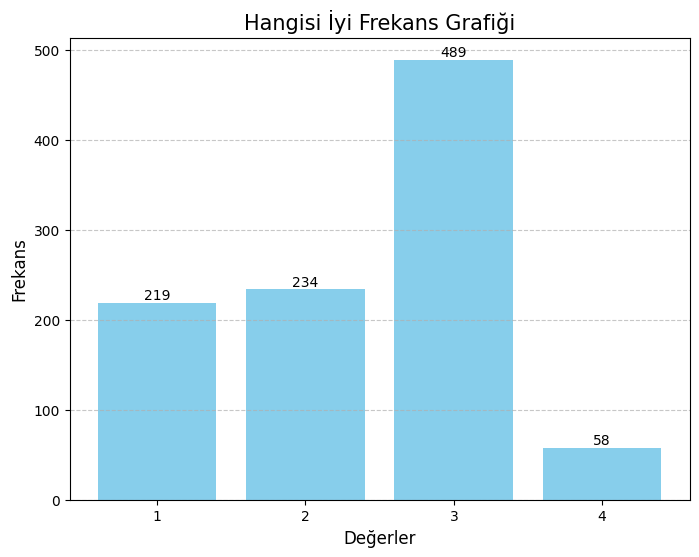

In [ ]:
counter = Counter(answers)
keys = [int(key) for key in counter.keys()]  # np.int64'ı int'e çeviriyoruz
values = list(counter.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(keys, values, color="skyblue")

plt.title("Hangisi İyi Frekans Grafiği", fontsize=15)
plt.xlabel("Değerler", fontsize=12)
plt.ylabel("Frekans", fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

plt.xticks(keys)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

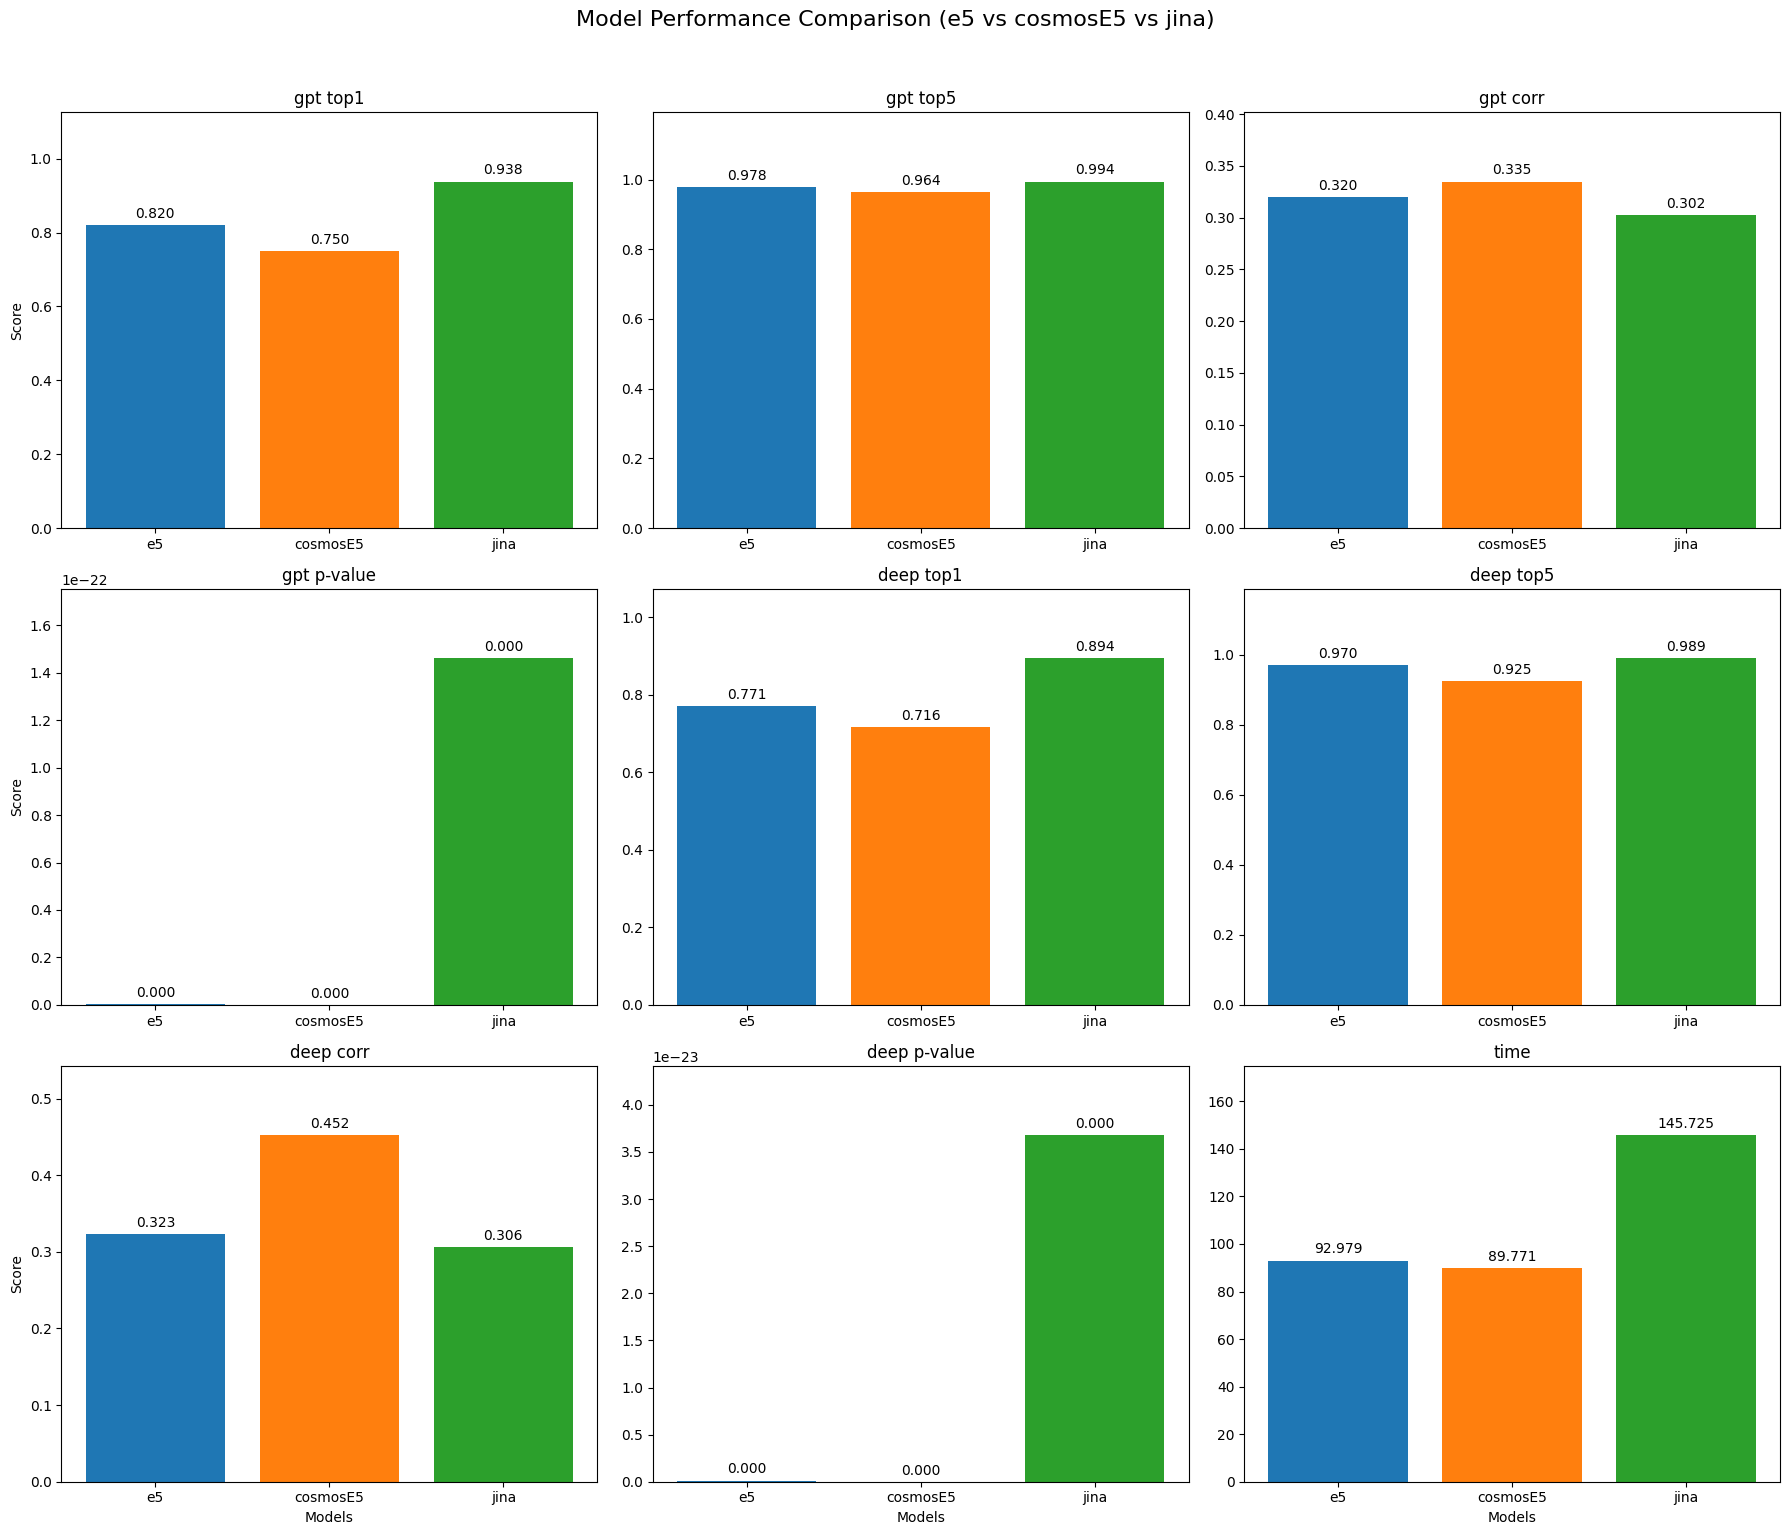

In [ ]:

def plot_model_comparison_metrics(
    e5_metrics, cosmosE5_metrics, jina_metrics, metric_names
):
    """
    3 model için 9 metriği gruplandırılmış çubuk grafiklerle karşılaştırır

    Parametreler:
    e5_metrics: e5 modeline ait 9 metrik değeri
    cosmosE5_metrics: cosmosE5 modeline ait 9 metrik değeri
    jina_metrics: jina modeline ait 9 metrik değeri
    metric_names: Metrik isimlerinin listesi (9 elemanlı)
    """
    models = ("e5", "cosmosE5", "jina")
    num_metrics = len(metric_names)

    # 3x3 grid oluştur (9 metrik için)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle(
        "Model Performance Comparison (e5 vs cosmosE5 vs jina)", fontsize=16, y=1.02
    )

    # Her bir metrik için grafik oluştur
    for i, (ax, metric_name) in enumerate(zip(axes.flat, metric_names)):
        # Modellerin o metriğe ait değerleri
        # Take the average for metrics like top1, top5 that are lists of values
        values = (
            np.mean(e5_metrics[i])
            if isinstance(e5_metrics[i], list)
            else e5_metrics[i],
            np.mean(cosmosE5_metrics[i])
            if isinstance(cosmosE5_metrics[i], list)
            else cosmosE5_metrics[i],
            np.mean(jina_metrics[i])
            if isinstance(jina_metrics[i], list)
            else jina_metrics[i],
        )

        # Çubuk grafik oluştur
        bars = ax.bar(models, values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

        # Çubuk üstüne değerleri yaz
        ax.bar_label(bars, padding=3, fmt="%.3f")

        # Grafik başlığı ve düzenleme
        ax.set_title(metric_name)
        ax.set_ylim(0, max(values) * 1.2)  # Otomatik yükseklik ayarı

        # Sadece sol ve alt kenardaki grafiklere etiket ekle
        if i in [6, 7, 8]:
            ax.set_xlabel("Models")
        if i in [0, 3, 6]:
            ax.set_ylabel("Score")

    plt.tight_layout()
    plt.show()


metric_names = [
    "gpt top1",
    "gpt top5",
    "gpt corr",
    "gpt p-value",
    "deep top1",
    "deep top5",
    "deep corr",
    "deep p-value",
    "time",
]


plot_model_comparison_metrics(results[0], results[1], results[2], metric_names)